# Quantum Singular Value Transform (QSVT) for matrix inversion

This notebook shows how to solve linear systems of equations using QSVT in PennyLane. The polynomial used corresponds to the polynomial of the pyqsp package https://github.com/ichuang/pyqsp.

In [1]:
# import python libraries
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

# Define linear system

In [2]:
A = np.array(
    [
        [0.65713691, -0.05349524, 0.08024556, -0.07242864],
        [-0.05349524, 0.65713691, -0.07242864, 0.08024556],
        [0.08024556, -0.07242864, 0.65713691, -0.05349524],
        [-0.07242864, 0.08024556, -0.05349524, 0.65713691],
    ]
)

b = np.array([1, 2, 3, 4], dtype="complex")
target_x = np.linalg.inv(A) @ b  # true solution

# Normalize states:
norm_b = np.linalg.norm(b)
b = b / norm_b

norm_x = np.linalg.norm(target_x)
normalized_x = target_x / norm_x

# Define QSVT circuit

In [3]:
def real_u(A, phi, qsvt_wires):
    qml.Hadamard(wires=qsvt_wires[0])

    qml.ctrl(qml.qsvt(A, phi, qsvt_wires[1:], convention="Wx"), control=qsvt_wires[0], control_values=(0,))
    qml.adjoint(qml.ctrl(qml.qsvt(A.T, phi, qsvt_wires[1:], convention="Wx"), control=qsvt_wires[0], control_values=(1,)))
    
    qml.Hadamard(wires=qsvt_wires[0])

def qsvt_ls(A, b, phi, qsvt_wires):
    qml.StatePrep(b, wires=qsvt_wires[2:])
    real_u(A.T, phi, qsvt_wires)  # invert the singular values of A transpose to get A^-1


# Find phase angles to approximate $\frac{1}{x}$ with a polynomial

The polynomial is defined by standard QSP operators. The phase angles are provided by the pyqsp library.

In [10]:
# Define condition number
kappa = 8.21

# Use pyqsp to determine phase angles
import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

pcoefs, s_pyqsp = pyqsp.poly.PolyOneOverX().generate(kappa, return_coef=True, ensure_bounded=True, return_scale=True, epsilon=0.001)
phi_pyqsp = QuantumSignalProcessingPhases(pcoefs, signal_operator="Wx", tolerance=0.00001)

# s_pyqsp = 0.10145775
# phi_pyqsp = [-1.5922142770532273, -0.03252949895974533, 0.06067372571024077, 0.3119249700528526, 0.21643648192810572, -0.6257675633866073, 2.2647603713275712, -2.9452302836036406, 0.7351754207364953, 0.2758836177105888, -0.11643337976620094, 0.649573162685275, 0.12829303551227234, -1.0892339063760752, 2.3144971667719467, -2.6272826402282705, -0.21949773265116868, 2.6389896276979274, -2.2213989345063783, 2.6543450662205297, -0.17021410564966066, -2.1307099378221315, 1.01088271573515, -0.17021410582656094, -0.487247587299507, 0.9201937191031345, -0.5026030261033417, -0.2194977327290849, 0.5143100130364344, -0.8270954871909815, 2.052358747478442, -3.0132996176161053, 0.6495731628695878, -0.11643337963853151, 0.27588361797184735, 0.7351754206492971, 0.19636236921530748, -0.8768322826914424, -0.6257675629979345, 0.21643648227708767, 0.31192496995906427, 0.06067372558084472, -0.03252949895439006, -0.0214179502139501]

b=607, j0=94
[PolyOneOverX] minimum [-15.73103908] is at [-0.04550377]: normalizing
[PolyOneOverX] bounding to 0.9


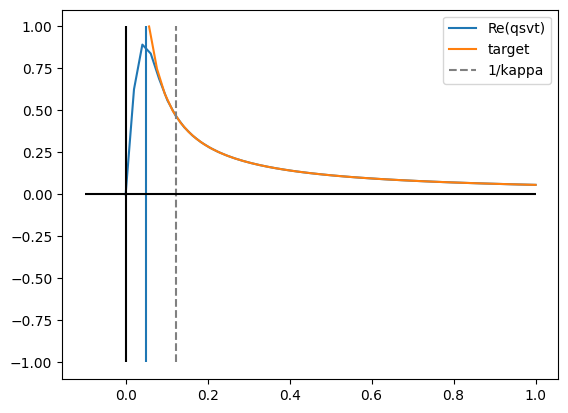

In [11]:
def plot_poly_pyqsp(phi, s, kappa):
    x_vals = np.linspace(0, 1, 50)
    target_y_vals = [s * (1 / x) for x in np.linspace(s, 1, 50)]

    qsvt_y_vals = []
    for x in x_vals:
        poly_x = qml.matrix(qml.qsvt_legacy, wire_order=[0])(
            x, phi, wires=[0], convention="Wx" 
        )
        qsvt_y_vals.append(np.real(poly_x[0, 0]))
    
    plt.plot(x_vals, np.array(qsvt_y_vals), label="Re(qsvt)")
    plt.plot(np.linspace(s, 1, 50), target_y_vals, label="target")
    plt.vlines(1/20, -1, 1)

    plt.vlines(1 / kappa, -1.0, 1.0, linestyle="--", color="grey", label="1/kappa")
    plt.vlines(0.0, -1.0, 1.0, color="black")
    plt.hlines(0.0, -0.1, 1.0, color="black")

    plt.legend()
    plt.show()

plot_poly_pyqsp(phi_pyqsp, s_pyqsp, kappa)

# Solve linear system using QSVT

In [6]:
ancilla_wires = [0]
block_wire = [1]
solution_wires = [2, 3]

wires = ancilla_wires + block_wire + solution_wires

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def solve_ls(A, b):
    qsvt_ls(A, b, phi_pyqsp, wires)

    return qml.state()

In [7]:
# Result by QSVT
qsvt_state = solve_ls(A, b)[:2**len(solution_wires)].real
print(qsvt_state/np.linalg.norm(qsvt_state))

[0.2053983  0.33532753 0.58192261 0.71185185]


In [8]:
# Expected result
print(normalized_x.real)

[0.20539461 0.33532754 0.58192117 0.71185409]


The solutions found by QSVT are close to the expected values (up to a constant).

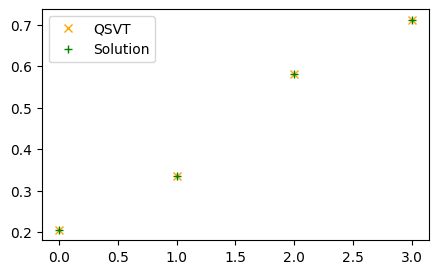

In [9]:
plt.figure(figsize=(5, 3))
plt.plot(qsvt_state/np.linalg.norm(qsvt_state), marker='x', c='orange', label="QSVT", ls="")
plt.plot(normalized_x.real, marker='+', c='green', label="Solution", ls="")
plt.legend()
plt.show()